### **INSTALL AND IMPORT LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### **IMPORT THE DATASET**

In [2]:
df = pd.read_parquet("../data/processed/dataset_features.parquet")
df

,url,result,visible_text,url_length,num_dots,has_at_symbol,uses_https,suspicious_words,has_ip_address,num_subdomains,is_suspicious_tld,has_hyphen,url_has_encoding,url_has_long_query,url_ends_with_exe,num_forms,num_inputs,num_links,num_password_inputs,num_hidden_inputs,num_onclick_events,num_hidden_elements,has_iframe,has_zero_sized_iframe,suspicious_form_action,has_script_eval,has_base64_in_js,num_inline_scripts,has_network_js,external_js_count,external_iframe_count,num_external_domains
0,https://docs.embotics.com/Service-Portal/vm_sn...,0,managing vm snapshots skip to main content acc...,63,3,False,True,0,False,1,False,False,False,False,False,1,1,21,0,0,1,4,False,False,False,False,False,3,False,10,0,1
1,https://csgocyber.ru/freeskin,1,navi - giveaway players shop astralis group na...,29,1,False,True,0,False,0,False,False,False,False,False,0,0,7,0,0,1,2,False,False,False,False,False,4,False,3,0,2
2,https://1stglobalcapitalinvestors.com/linkedin...,1,,58,1,False,True,0,False,0,False,False,False,False,False,0,0,0,0,0,0,0,False,False,False,False,False,1,False,1,0,0
3,https://help.foxnews.com/hc/en-us/sections/206...,0,community and registration fox news fox news ...,79,2,False,True,0,False,1,False,False,False,False,False,1,2,19,0,1,0,0,False,False,False,False,False,2,False,7,0,4
4,https://www.calculatorsoup.com/calculators/mat...,0,long division calculator with remainders you m...,64,3,False,True,0,False,1,False,False,False,False,False,1,7,31,0,2,1,0,False,False,False,False,False,5,False,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,Https://viabcp.moaqt.com,1,,24,2,False,True,0,False,1,False,False,False,False,False,0,0,0,0,0,0,0,False,False,False,False,False,0,False,0,0,0
59996,http://bonprixsklep.com.pl/glosowanie,1,welcome to facebook facebook facebook you must...,37,2,False,False,0,False,1,False,False,False,False,False,1,12,6,1,10,0,3,False,False,False,False,False,17,False,28,0,2
59997,https://www.sbs.com.au/,0,"sbs tv sbs radio sbs on demand, news, sport,...",23,3,False,True,0,False,2,False,False,False,False,False,1,2,146,0,0,0,15,False,False,False,False,False,7,True,2,0,2
59998,https://www.analystforum.com/t/type-i-vs-type-...,0,type i vs. type ii errors - quant - analystfor...,61,2,False,True,0,False,1,False,False,False,False,False,0,0,30,0,0,0,0,False,False,False,False,False,1,False,3,0,2


### **DATASET OVERVIEW**

**BASIC INFO**

In [3]:
print("\nDataset Info:")
print(df.info())

print("\nMissing Values per Column:")
print(df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   url                     60000 non-null  object
 1   result                  60000 non-null  int64 
 2   visible_text            60000 non-null  object
 3   url_length              60000 non-null  int64 
 4   num_dots                60000 non-null  int64 
 5   has_at_symbol           60000 non-null  bool  
 6   uses_https              60000 non-null  bool  
 7   suspicious_words        60000 non-null  int64 
 8   has_ip_address          60000 non-null  bool  
 9   num_subdomains          60000 non-null  int64 
 10  is_suspicious_tld       60000 non-null  bool  
 11  has_hyphen              60000 non-null  bool  
 12  url_has_encoding        60000 non-null  bool  
 13  url_has_long_query      60000 non-null  bool  
 14  url_ends_with_exe       60000 non-null 

The dataset contained 60,000 entries with 32 features, covering a wide range of characteristics such as URL structure, security indicators, and HTML/JavaScript elements for classification. All columns were complete with no missing values, which ensured that the dataset was clean and ready for analysis without requiring imputation or additional preprocessing for null handling. Having a well-structured and comprehensive dataset provided a strong foundation for building and evaluating phishing detection models, as it captured both content-based and behavior-based indicators that distinguished legitimate websites from phishing attempts.

**CLASS DISTRIBUTION**

Class Distribution:
result
0    30000
1    30000
Name: count, dtype: int64


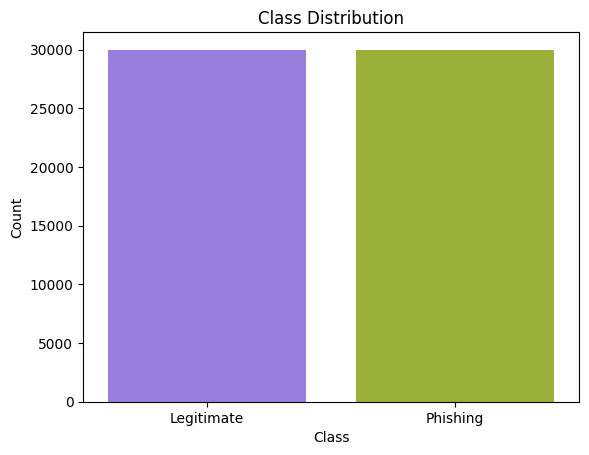

In [4]:
print("Class Distribution:")
print(df["result"].value_counts())

# Custom colors
palette = {"0": "#916FEE", "1": "#A7C526"}  # 0 = Legitimate, 1 = Phishing

df["result_str"] = df["result"].astype(str)
sns.countplot(x="result_str", data=df, hue="result_str", palette=palette, legend=False)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ["Legitimate", "Phishing"])
os.makedirs("../results/eda/", exist_ok=True)
plt.savefig("../results/eda/class_distribution.png", dpi=300)
plt.show()

The class distribution indicated an even split between legitimate and phishing websites, with 30,000 samples in each category. This balance prevented the learning algorithm from favoring one class over the other, a common issue in imbalanced datasets. With equal representation, evaluation metrics such as accuracy, precision, recall, and F1-score provided a fairer measure of model performance. As a result, this dataset offered a strong foundation for developing and testing phishing detection models without the risk of class bias.

### **TEXTUAL FEATURES ANALYSIS**

**TOKEN COUNT DISTRIBUTION**

In [5]:
# Token count computation
df["token_count"] = df["visible_text"].apply(lambda x: len(str(x).split()))

# Separate by class
legitimate = df[df["result"] == 0]["token_count"]
phishing = df[df["result"] == 1]["token_count"]

# Summary statistics
percentiles = [50, 75, 90, 95, 99]
summary = np.percentile(df["token_count"], percentiles)
summary_df = pd.DataFrame({
    "Percentile": percentiles,
    "Token Count": summary
})
print("Token Count Percentile Summary:")
print(summary_df)

Token Count Percentile Summary:
   Percentile  Token Count
0          50       140.00
1          75       803.00
2          90      1762.00
3          95      2752.05
4          99      6801.01


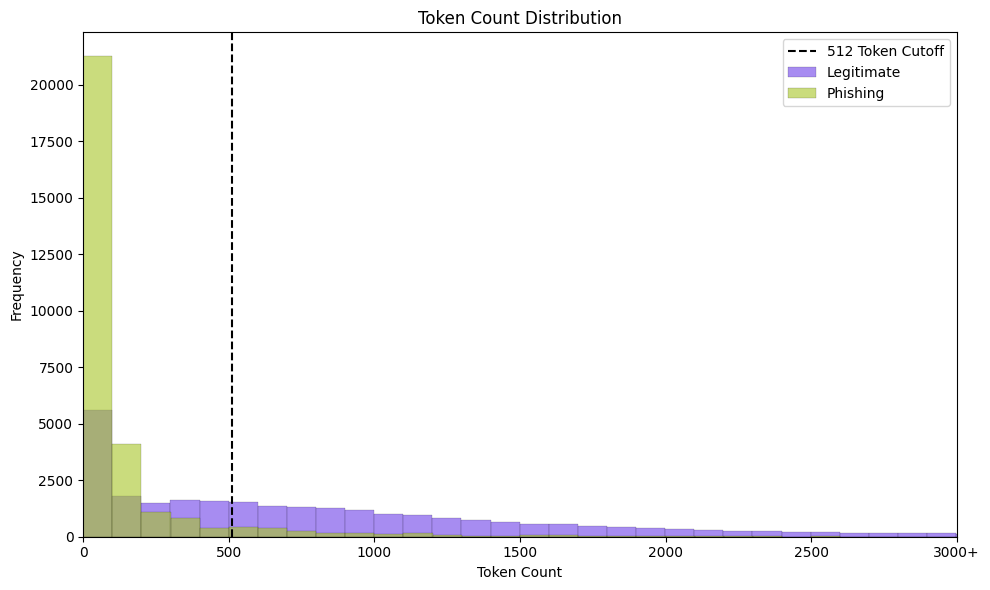

In [6]:
# Custom colors
palette = {0: "#916FEE", 1: "#A7C526"}  # 0 = Legitimate, 1 = Phishing

# Plot token count distribution
plt.figure(figsize=(10, 6))
sns.histplot(legitimate, color=palette[0], label="Legitimate", binwidth=100, alpha=0.8)
sns.histplot(phishing, color=palette[1], label="Phishing", binwidth=100, alpha=0.6)

# Mark 512-token cutoff
plt.axvline(512, color="black", linestyle="--", label="512 Token Cutoff")

# Set zoom range
upper_limit = 3000
plt.xlim(0, upper_limit)

# Add '+' to last x-tick label to indicate cutoff
ticks = plt.xticks()[0]
tick_labels = [f"{int(t)}" for t in ticks]
if tick_labels:
    tick_labels[-1] = tick_labels[-1] + "+"
plt.xticks(ticks, tick_labels)

plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
os.makedirs("../results/eda/", exist_ok=True)
plt.savefig("../results/eda/token_count_distribution.png", dpi=300)
plt.show()

In [7]:
over_512 = (df["token_count"] > 512).mean() * 100
print(f"Samples exceeding 512 tokens: {over_512:.2f}%")

Samples exceeding 512 tokens: 33.47%


The token count distribution reveals a heavy-tailed pattern, with most samples being relatively short but a subset extending into several thousand tokens. The percentile summary shows that 50% of samples contain fewer than 140 tokens, and 75% fall below 803 tokens. Approximately 33.47% of samples exceed 512 tokens.

Although a third of samples are longer than the 512-token limit, this threshold was selected based on the BERT models context capacity and inference constraints. Empirically, most phishing-relevant cues (e.g., login prompts, brand names, and calls to action) appear within the first 512 tokens of the visible text. Therefore, truncating beyond this point minimizes computational cost while retaining critical information for classification.

**TOP KEYWORDS COMPARISON**

In [8]:
# Function to get the top keywords (unigrams)
def get_top_keywords(corpus, n=None):
    vec = CountVectorizer(stop_words="english", ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = []
    for word, idx in vec.vocabulary_.items():
        if re.search(r"\d", word):
            continue
        words_freq.append((word, sum_words[0, idx]))
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(sorted_words, columns=["keyword", "frequency"])

# Top keywords in legitimate sites
print("Top 5 keywords in legitimate:")
top_keywords_legitimate = get_top_keywords(df[df["result"] == 0]["visible_text"], n=5)
print(top_keywords_legitimate)

# Top keywords in phishing sites
print("\nTop 5 keywords in phishing:")
top_keywords_phishing = get_top_keywords(df[df["result"] == 1]["visible_text"], n=5)
print(top_keywords_phishing)

Top 5 keywords in legitimate:
       keyword  frequency
0          new      76935
1          use      68564
2         data      58838
3  information      51582
4         free      48604

Top 5 keywords in phishing:
    keyword  frequency
0   banking      21366
1      sign      21248
2   account      20226
3  password      17564
4      help      16803


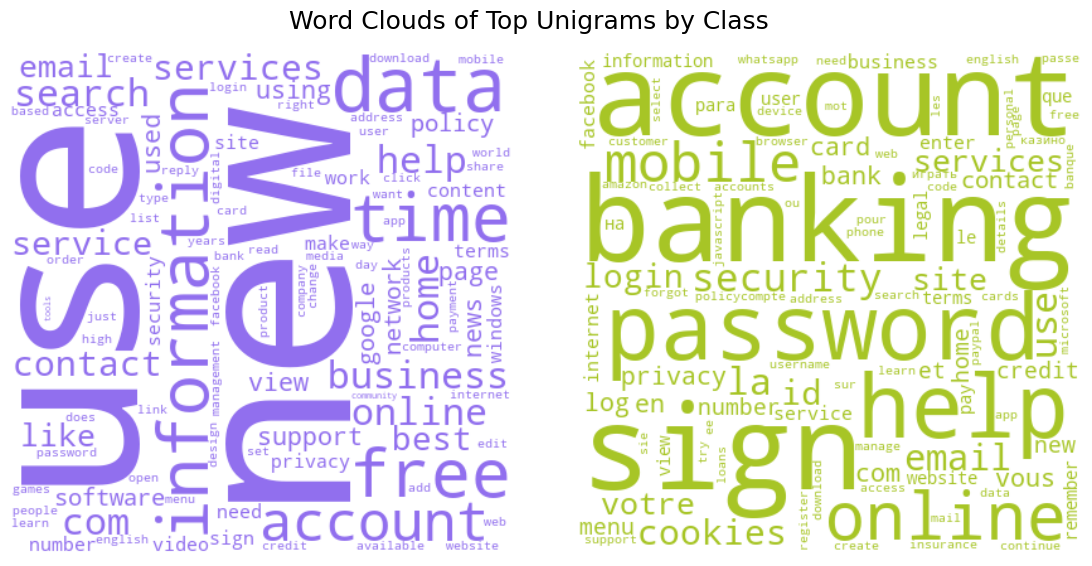

In [9]:
# Custom colors
palette = {0: "#916FEE", 1: "#A7C526"}  # 0 = Legitimate, 1 = Phishing

# Function to generate word cloud from frequency dictionary
def generate_wordcloud_from_freq(df_keywords, color):
    freq_dict = dict(zip(df_keywords["keyword"], df_keywords["frequency"]))
    return WordCloud(
        width=400,
        height=400,
        background_color="white",
        colormap=None,
        color_func=lambda *args, **kwargs: color
    ).generate_from_frequencies(freq_dict)

# Generate word clouds
top_keywords_legitimate = get_top_keywords(df[df["result"] == 0]["visible_text"], n=100)
top_keywords_phishing = get_top_keywords(df[df["result"] == 1]["visible_text"], n=100)
wc_legit = generate_wordcloud_from_freq(top_keywords_legitimate, palette[0])
wc_phish = generate_wordcloud_from_freq(top_keywords_phishing, palette[1])

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Word Clouds of Top Unigrams by Class", fontsize=18, y=1.02)

for ax, wc, in zip(axes, [wc_legit, wc_phish]):
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    
plt.subplots_adjust(wspace=0.1, top=0.95)
plt.savefig("../results/eda/word_cloud_visualization.png", dpi=300)
plt.show()

The top keyword comparison revealed clear linguistic distinctions between legitimate and phishing websites. Legitimate pages frequently used general or informational terms such as "new", "use", "data", "information", and "business", which typically appear in product descriptions, news articles, and policy sections. In contrast, phishing pages prominently featured credential- and security-related terms like "banking", "sign", "account", "password", and "security". This contrast suggests that phishing websites are linguistically tailored to imitate login or financial service pages and to solicit user credentials, while legitimate sites focus on content dissemination and transparency. These distinctive keyword patterns provide valuable textual cues that the model can exploit to differentiate malicious sites from legitimate ones.

**WORD CLOUD VISUALIZATION**

### **HEURISTIC FEATURES ANALYSIS**

**FEATURE CORRELATION ANALYSIS**

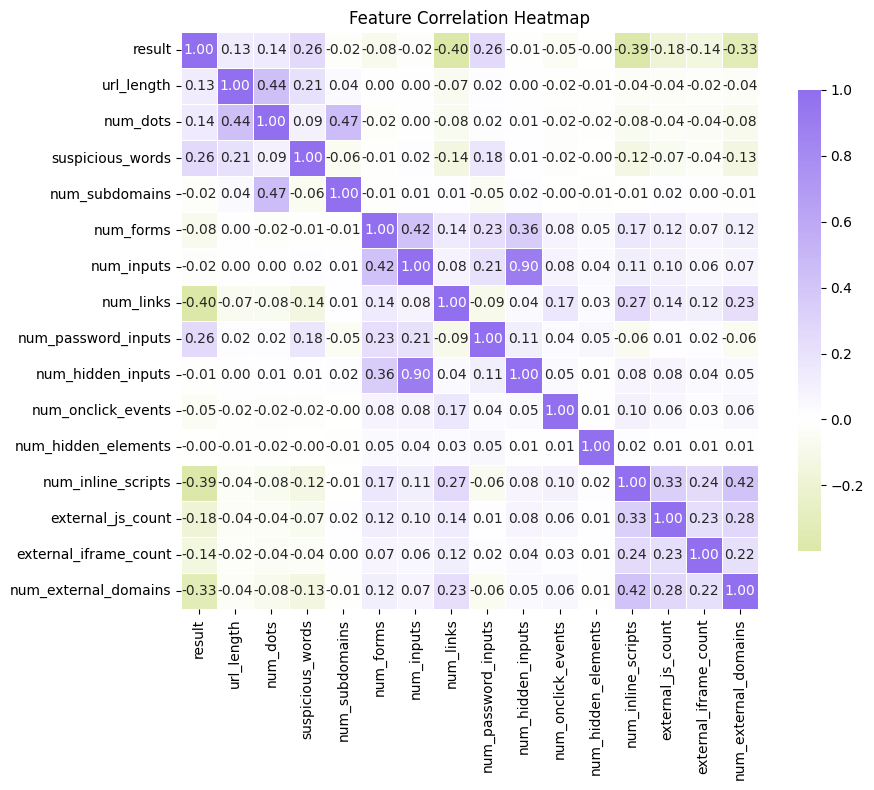

In [9]:
# Select numeric features
numeric_df = df.select_dtypes(include=[np.number])
numeric_df = numeric_df.drop(columns=["token_count"])

# Create a custom diverging colormap
colors = ["#A7C526", "#FFFFFF", "#916FEE"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

plt.figure(figsize=(10, 8))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    fmt=".2f",
    cmap=cmap,
    center=0,        # zero correlation centered
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Feature Correlation Heatmap")
plt.tight_layout()
os.makedirs("../results/eda/", exist_ok=True)
plt.savefig("../results/eda/feature_correlation_heatmap.png", dpi=300)
plt.show()

The correlation heatmap revealed several key relationships among the heuristic features. Notably, negatively correlated indicators such as the number of links (−0.40), inline scripts (−0.39), external domains (−0.33), and token count (−0.36) suggested that phishing websites tend to include numerous embedded links and scripts while maintaining concise or obfuscated textual content to conceal intent. Conversely, features such as the presence of suspicious words and password input fields showed moderate positive correlations with phishing likelihood (both around 0.26), reinforcing their value as direct indicators of malicious intent.

Strong inter-feature dependencies were also observed, particularly between the number of inputs and hidden inputs (0.90), indicating structural similarity among certain web components. Despite these correlations, all heuristic variables were retained during model training to preserve potentially complementary signals. Allowing the learning algorithms to assign feature importance internally enabled the model to capture non-linear and joint effects across heuristics, enhancing its ability to identify subtle phishing patterns beyond individual feature relationships.

**CLASS SEPARABILITY VISUALIZATION**

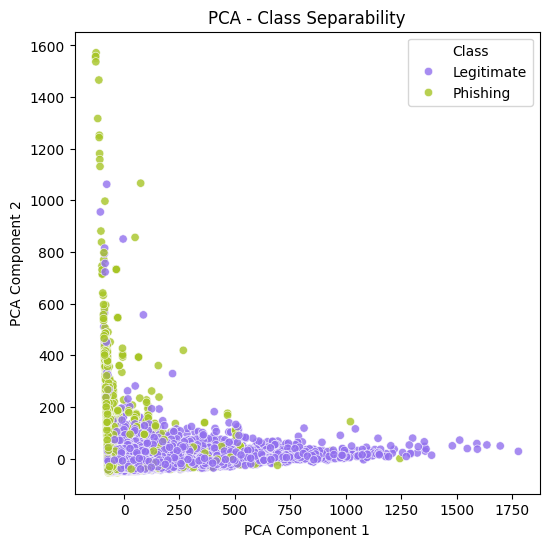

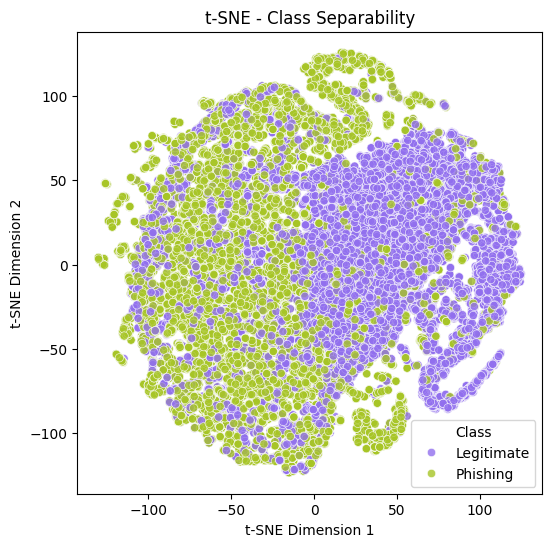

In [10]:
# Map result to class labels
df["Class"] = df["result"].map({0: "Legitimate", 1: "Phishing"})

# Select numeric heuristic features
numeric_df = df.select_dtypes(include=[np.number])
X = numeric_df.drop(columns=["result", "token_count"])
y = df["Class"]

# Custom colors
palette = {"Legitimate": "#916FEE", "Phishing": "#A7C526"}

# PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)
plt.figure(figsize=(6,6))
sns.scatterplot(
    x=pca_result[:,0],
    y=pca_result[:,1],
    hue=y,
    palette=palette,
    alpha=0.8
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA - Class Separability")
os.makedirs("../results/eda/", exist_ok=True)
plt.savefig("../results/eda/pca_class_separability.png", dpi=300)
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(X)
plt.figure(figsize=(6,6))
sns.scatterplot(
    x=tsne_result[:,0],
    y=tsne_result[:,1],
    hue=y,
    palette=palette,
    alpha=0.8
)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE - Class Separability")
os.makedirs("../results/eda/", exist_ok=True)
plt.savefig("../results/eda/tsne_class_separability.png", dpi=300)
plt.show()

The PCA plot, although useful for linear dimensionality reduction, showed limited class separability, with phishing and legitimate instances remaining substantially overlapped across the principal components. This indicates that linear projection methods are unable to capture the underlying structure of the dataset, suggesting that the feature space contains complex, non-linear interactions that cannot be represented through simple linear combinations of variables. In contrast, the t-SNE visualization demonstrated a more pronounced separation between the two classes, with phishing and legitimate samples forming locally coherent clusters despite some regions of overlap. This contrast between PCA and t-SNE embeddings confirms that the data exhibit non-linear patterns and local neighborhood structures. Consequently, these findings support the use of non-linear modeling approaches for the downstream classification task, as they are better suited to capture the intricate feature relationships present in phishing detection.